# Otimizadores do Gradiente Descendente

## Objetivos

Os objetivos deste notebook são:

* ilustrar vários otimizadores do Gradiente Descendente:
    - SGD normal
    - SGD com momentum
    - SGD com momentum e Nesterov
    - RMSprop
    - Adam

A ilustração é feita no problema de regressão linear, com a visualização
da evolução dos parâmetros treinados no espaço de parâmetros onde a função
de perda é visualizada.


Este exercício foi inspirado no tutorial apresentado em: https://morvanzhou.github.io/tutorials/

Este post tem uma excelente descrição dos principais métodos de otimização:
http://ruder.io/optimizing-gradient-descent/


## Métodos de otimização do gradiente descendente estocástico com mini-batch

### Gradiente descendente

$$ W_{t+1} = W_t - \eta \nabla J(W_t) $$

### Gradiente descendente - Momentum


$$ v_{t+1} = \gamma v_t + \nabla J(W_t) $$
$$ W_{t+1} = W_t - \eta v_{t+1}$$

### Gradiente descendente - Momentum - Nesterov

$$ v_{t+1} = \gamma v_{t} + \nabla J(W_t - \gamma v_{t}) $$
$$ W_{t+1} = W_{t} - \eta v_{t+1}$$

### Gradiente descendente - Métodos com learning rates diferentes para cada dimensão do gradiente


$$ W_{t+1,i} = W_{t,i} - \frac{\eta}{\sqrt{G_{t,ii} + \epsilon}} \nabla J(W_t)$$

- Adagrad: Termo $G_{t,ii}$ é soma do quadrado dos gradientes na época
- RMSprop e Adadelta: Termo $G_{t,ii}$ é média móvel do termo $G$ passada (possui termo momentum)
- Adam: adiciona a média móvel tanto no termo $G$ mas também no gradiente $\nabla J(W)$

### Ilustração vários métodos

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/contours_evaluation_optimizers.gif)
![alt text](https://raw.githubusercontent.com/vcasadei/images/master/saddle_point_evaluation_optimizers.gif)


## Importação das bibliotecas

In [1]:
# http://pytorch.org/
from os.path import exists

import torch

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
import numpy as np
from sklearn.datasets import  load_iris

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

## Conjunto de dados: Iris

In [3]:
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x_in = data[:,0:1]
y_in = data[:,1:2]

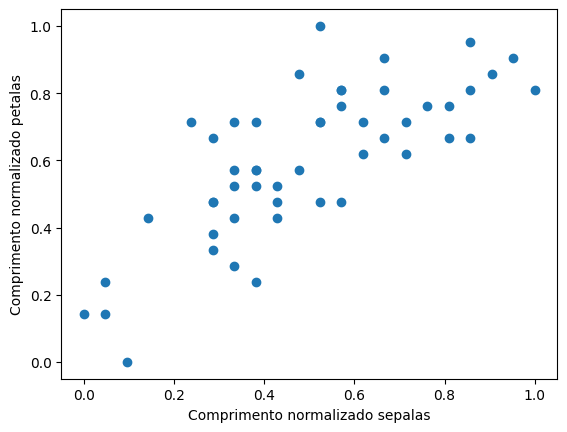

In [4]:
x = x_in - x_in.min()
x /= x.max()    # normalização
y = y_in - y_in.min()
y /= y.max()

plt.scatter(x, y)
plt.xlabel('Comprimento normalizado sepalas')
plt.ylabel('Comprimento normalizado petalas');

## Laço de minimização via gradiente descendente

O código da próxima célula é a parte principal deste notebook. É aqui que a minimização é feita. É aqui que dizemos que estamos fazendo o *fit*, ou o treinamento do sistema para encontrar o parâmetro $\mathbf{W}$ que minimiza a função de perda $J$. Acompanhamos a convergência da minimização pelo valor da perda a cada iteração, plotando o vetor `J_history`.

O esquema da otimização é representado pelo diagrama a seguir:

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLinear_Otimizacao.png)

e é implementado pela próxima célula de código:

### Função de Custo

In [5]:
def compute_cost(X_b, y, wT):
    '''
    Compute cost for linear regression
    (X,y): amostras rotuladas X(n_samples,2) e y(n_samples,)
    wT: vetor coluna de parâmetros (já transposto)
       aceita tanto shape (2,1) Para um caso como (2,n_history) para n_history casos
    '''
    e = X_b.dot(wT) - y
    J = (e * e).mean(axis=0)
    return J

### Função com laço de minimização do gradiente descendente

In [6]:
def train_net(X, y, lr=0.5, n_epochs=50, batch_size=10, shuffle=True, rnd_seed=445, optim='sgd'):
    torch.manual_seed(rnd_seed)
    # Data Loader
    dloader = DataLoader(TensorDataset(torch.from_numpy(X.astype(np.float32)),
                                       torch.from_numpy(y.astype(np.float32))),
                         batch_size=batch_size, shuffle=shuffle)
    # Modelo da rede
    model = torch.nn.Linear(1, 1)
    model.load_state_dict(dict(weight=torch.zeros(1,1), bias=torch.zeros(1)))
    # Função de perda
    criterion = torch.nn.MSELoss()
    # Otimizador do gradiente descendente
    opt_index = {'sgd'     :torch.optim.SGD(model.parameters(),    lr=lr),
                 'momentum':torch.optim.SGD(model.parameters(),    lr=lr, momentum=0.9),
                 'nesterov':torch.optim.SGD(model.parameters(),    lr=lr, momentum=0.9, nesterov=True),
                 'rmsprop' :torch.optim.RMSprop(model.parameters(),lr=lr, alpha=0.9),
                 'adam'    :torch.optim.Adam(model.parameters(),   lr=lr, betas=(0.9, 0.99))}
    optimizer = opt_index[optim]
    losses = []
    w_history = np.zeros((n_epochs + 1, 2), np.float32)
    model.train(True)
    # Laço de treinamento - epocas
    for epoch in range(n_epochs):
        cost = 0
        samp = 0
        for x, y in dloader:
            optimizer.zero_grad()
            pred = model(Variable(x))
            loss = criterion(pred, Variable(y))
            loss.backward()
            optimizer.step()

            cost += loss.data
            samp += 1

        losses.append(cost / samp)
        w, b = [ww.data for ww in model.parameters()]
        w_history[epoch + 1, 0] = b[0]
        w_history[epoch + 1, 1] = w[0, 0]

    return losses, w_history


### Função de plot interativo

In [7]:
def show_plots(x, y, lr=0.5, n_epochs=50, n_batch=50, shuffle=True, sleep=0.3,optim='sgd'):
    n_samples = y.shape[0]

    # minimização via gradiente descendente
    # -------------------------------------
    J_history, w_history = train_net(x, y, lr=lr, n_epochs=n_epochs, batch_size=n_batch, shuffle=shuffle,optim=optim)

    # valor ótimo, solução analítica
    # ------------------------------
    X_bias = np.hstack([np.ones((n_samples, 1)), x])
    w_opt = (np.linalg.inv((X_bias.T).dot(X_bias)).dot(X_bias.T)).dot(y)
    X_all = np.linspace(x.min(), x.max(), 100).reshape(100, 1)
    X_all_bias = np.hstack([np.ones((100, 1)), X_all])
    result_opt = X_all_bias.dot(w_opt)    # Predição do valor ótimo

    # matriz bidimensional de parâmetros
    # ----------------------------------
    wmin = w_history.min(axis=0)
    wmax = w_history.max(axis=0)
    D = wmax - wmin
    wmin -= D
    wmax += D
    ww0, ww1 = np.meshgrid(np.linspace(wmin[0], wmax[0], 100), np.linspace(wmin[1], wmax[1], 100))
    w_grid = np.c_[ww0.ravel(), ww1.ravel()]
    J_grid = compute_cost(X_bias, y, w_grid.T)
    J_grid = J_grid.reshape(ww0.shape)

    # Gráficos:
    # --------
    fig = plt.figure(figsize=(18, 6))
    ax_line = fig.add_subplot(1, 3, 1)    # linha reta
    ax_grid = fig.add_subplot(1, 3, 2)
    ax_loss = fig.add_subplot(1, 3, 3)    # função perda

    ax_loss.plot(J_history)
    ax_loss.set_title('Perda', fontsize=15)
    ax_loss.set_xlabel('epochs', fontsize=10)
    ax_loss.set_ylabel('MSE', fontsize=10)

    ax_line.scatter(x, y, marker='o', c='b')    # plotagem dos pontos azuis no Iris dataset
    ax_line.set_title('Iris dataset', fontsize=15)
    ax_line.set_xlabel('x', fontsize=10)
    ax_line.set_ylabel('y', fontsize=10)
    ax_line.plot(X_all, result_opt, c='r')      # solução analítica, reta vermelha Iris dataset

    ax_grid.pcolormesh(ww0, ww1, J_grid, cmap=plt.cm.coolwarm)
    ax_grid.contour(ww0, ww1, J_grid, 20)
    ax_grid.scatter(w_opt[0], w_opt[1], marker='x', c='w') # Solução analítica
    ax_grid.set_title('W', fontsize=15)
    ax_grid.set_xlabel('w0', fontsize=10)
    ax_grid.set_ylabel('w1', fontsize=10)

    # Plot dinâmico
    # -------------
    n_delta = n_samples // n_batch
    ln_v = np.zeros(n_samples, dtype=object)
    ln, sc = None, None
    for i, w in enumerate(w_history):
        if ln: ln.remove()
        if sc: sc.remove()
        [lnv.remove() for lnv in ln_v if lnv != 0]

        y_hat = X_all_bias.dot(w.T)    # Predição via minimização gradiente descendente
        w = w.reshape(1, 2)
        J = compute_cost(X_bias, y, w.T)

        ax_loss.scatter(i, J)

        ln, = ax_line.plot(X_all, y_hat, c='k', lw=2)    # reta preta iris dataset

        y_pred = X_bias.dot(w.T)
        sc = ax_line.scatter(x, y_pred, c='k', marker='x')
        for k in range(n_samples):
            ln_v[k], = ax_line.plot([x[k], x[k]], [y_pred[k], y[k]], c='y')

        ax_grid.scatter(w_history[i,0], w_history[i,1], c='r', marker='o')

        display.display(fig)
        display.clear_output(wait=True)
        time.sleep(sleep)


## Plotagem iterativa do gradiente descendente, reta ajuste, parâmetros, função perda

### Otimizador básico SGD Stochastic Gradient Descent

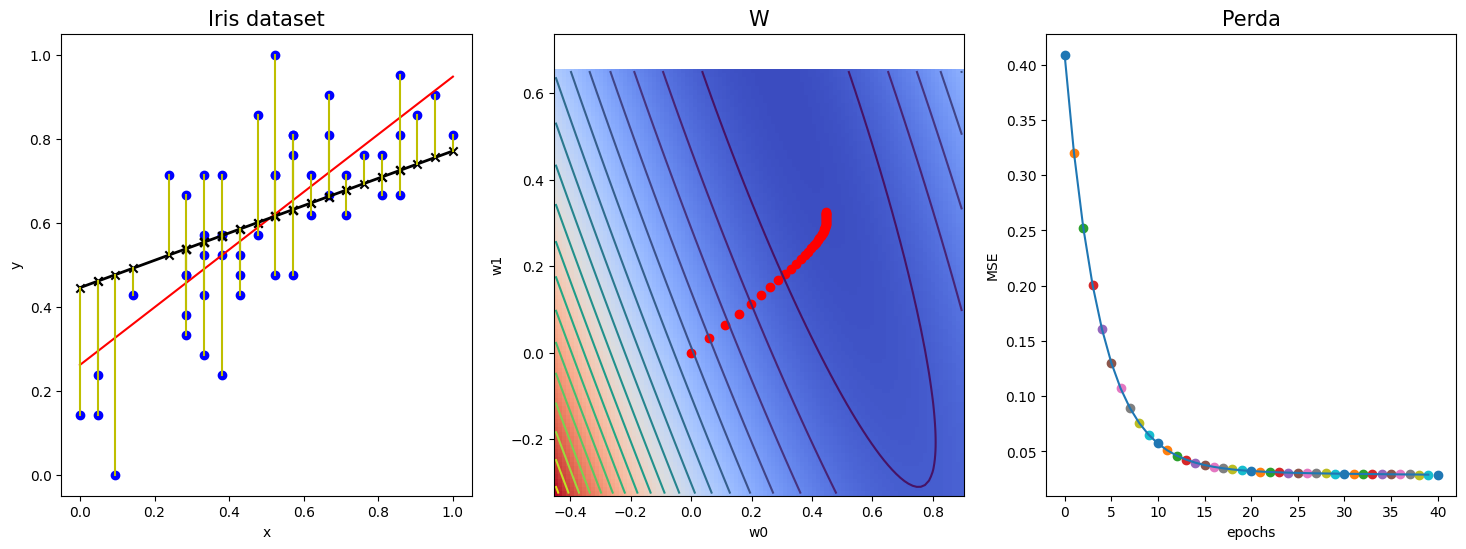

In [8]:
try:
    show_plots(x, y, lr=0.05, n_epochs=40, n_batch=50, sleep=0.1,optim='sgd')
except KeyboardInterrupt:
    pass

### SGD com momentum

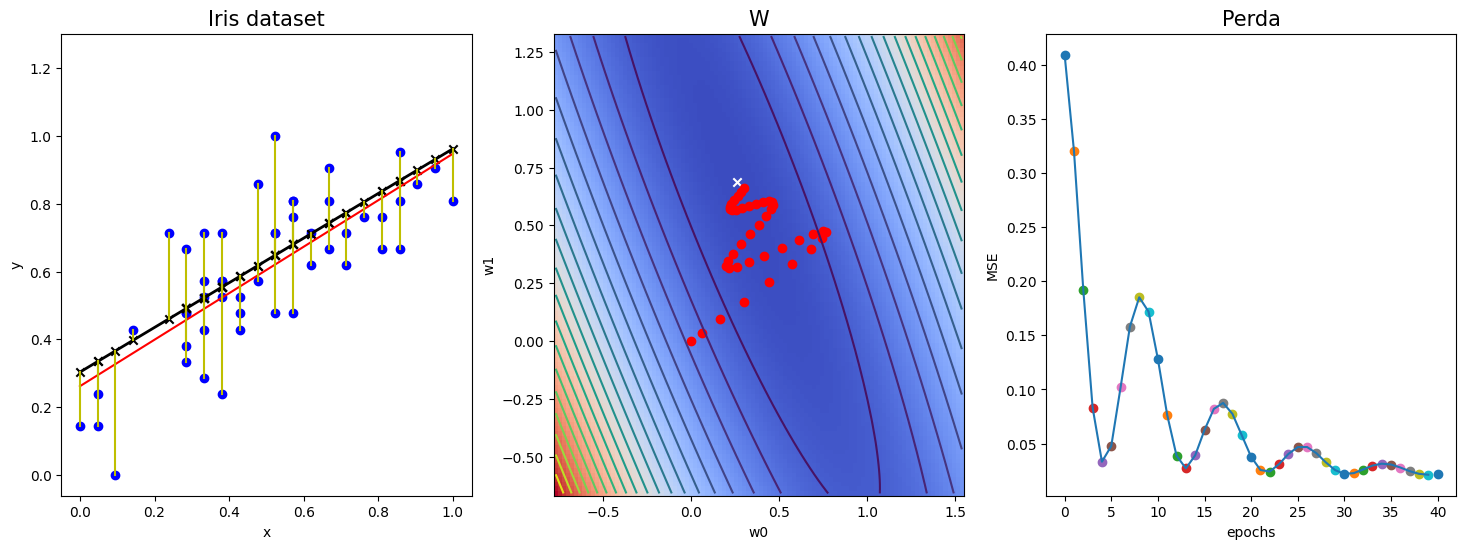

In [9]:
try:
    show_plots(x, y, lr=0.05, n_epochs=40, n_batch=50, sleep=0.1,optim='momentum')
except KeyboardInterrupt:
    pass

### SGD com momentum Nesterov

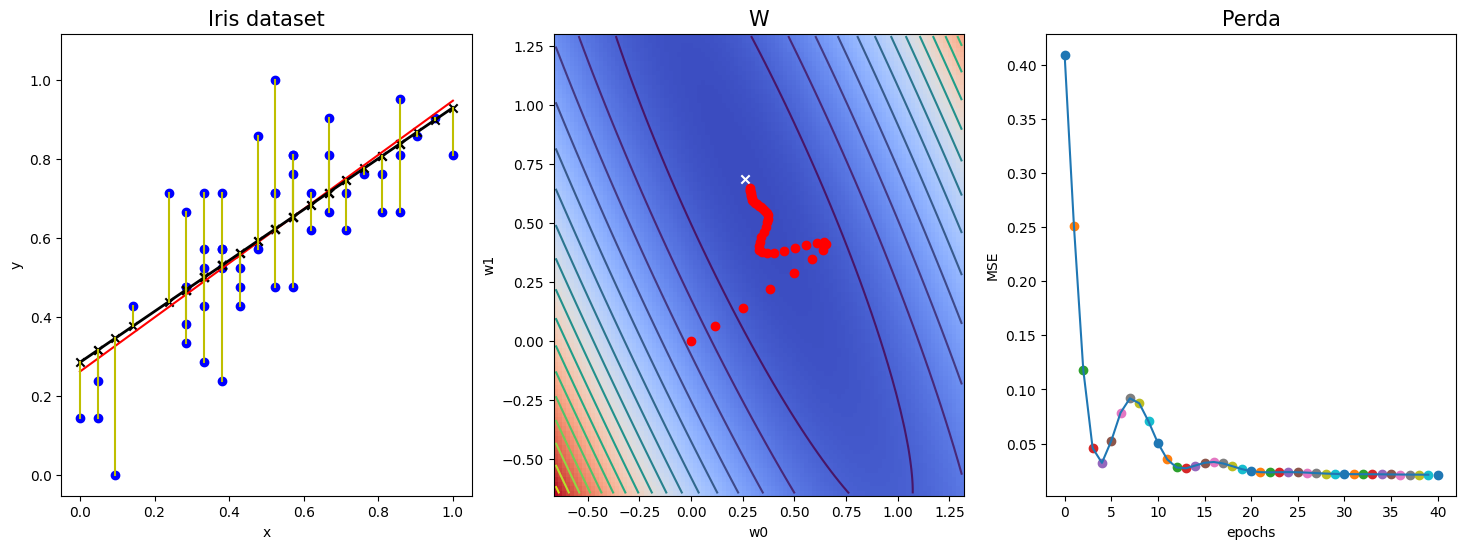

In [10]:
try:
    show_plots(x, y, lr=0.05, n_epochs=40, n_batch=50, sleep=0.1,optim='nesterov')
except KeyboardInterrupt:
    pass

### Otimizador RMSprop

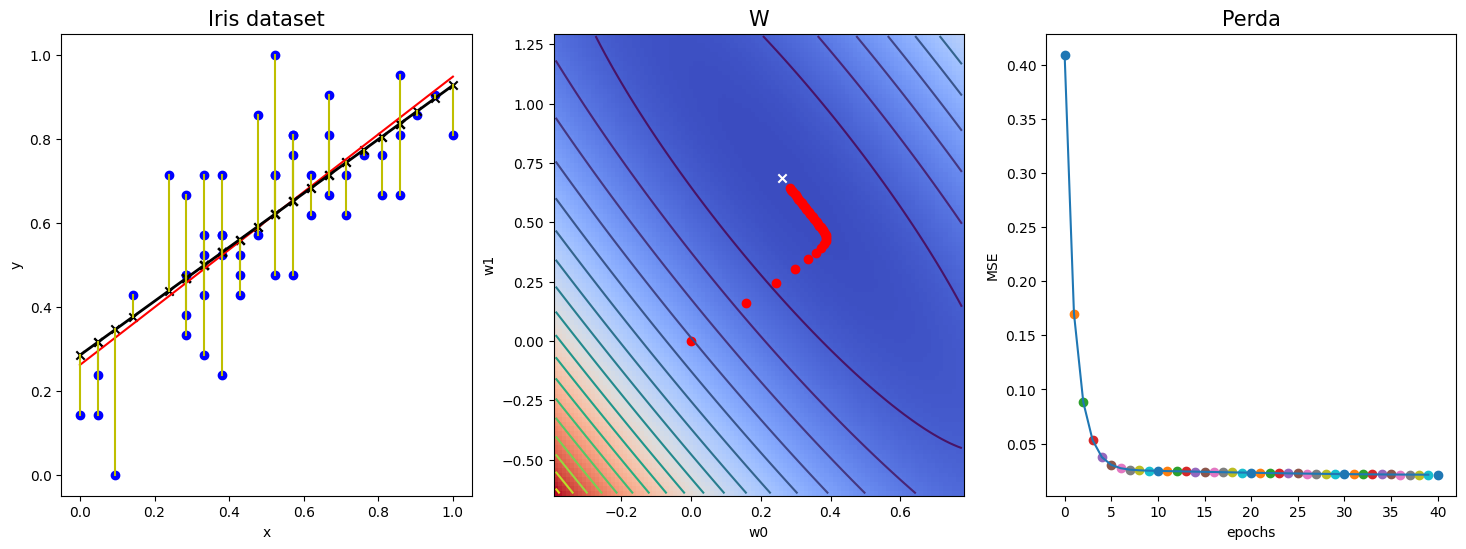

In [11]:
try:
    show_plots(x, y, lr=0.05, n_epochs=40, n_batch=50, sleep=0.1,optim='rmsprop')
except KeyboardInterrupt:
    pass

### Otimizador Adam

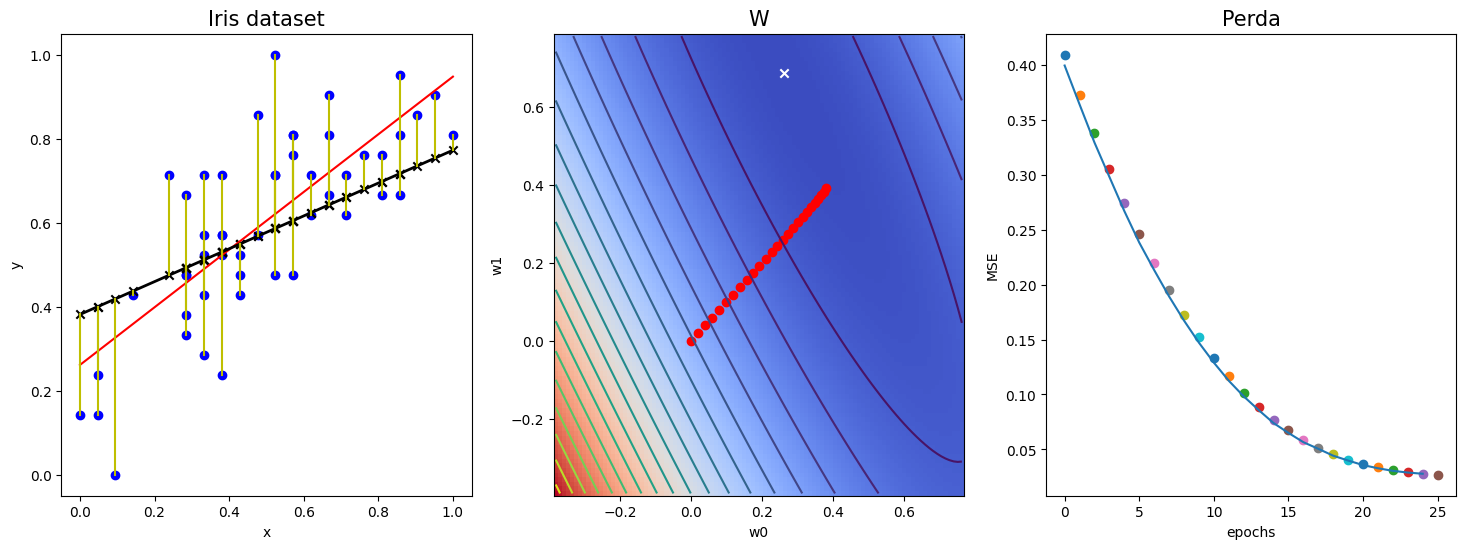

In [12]:
try:
    show_plots(x, y, lr=0.01, n_epochs=25, n_batch=25, sleep=0.1,optim='adam')
except KeyboardInterrupt:
    pass

## Exercícios

1. Em cada uma dos experimentos com otimizar, procure sintonizar os valores de 1) LR; 2) Batch-size para que a convengência para o parâmetro ótimo seja a mais rápida e melhor possível.

## Conclusões desse experimento

Quais são as principais conclusões que podemos tirar deste experimento?
  - Ao aplicar diferentes formas de gradiente descendente podemos concluir que a depender dos dados e dos parâmetros que utilizamos pode-se obter uma melhor performance, não apensar com o parâmetro mas também com a complexidade dos dados, principalmente adam que apesar de ser o mais rápido se os dados forem mais lineares (não tão complexos), ele pode perder a performance.
